In [1]:
import pandas as pd
import numpy as np
import string
from sklearn.linear_model import LogisticRegression
from nltk.stem.porter import PorterStemmer
import nltk
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report, roc_auc_score
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt

import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [2]:
try:
    from google.colab import drive
    drive.mount('/content/drive/')
    path = '/content/drive/MyDrive/NLP/'
except:
    path = ''

# Подгрузка данных

In [3]:
df = pd.read_csv(path + 'data/all_dfs.csv', index_col = 0)
df.head()

,news,target
0,The international electronic industry company ...,0
1,With the new production plant the company woul...,1
2,According to the company 's updated strategy f...,1
3,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...,1
4,"For the last quarter of 2010 , Componenta 's n...",1


<AxesSubplot:xlabel='index', ylabel='target'>

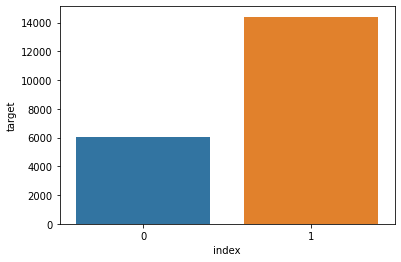

In [4]:
class_counts = df['target'].value_counts().to_frame().reset_index()

sns.barplot(y = class_counts['target'], x = class_counts['index'])

## Function preprocessing

In [5]:
# functions

def preprocessing(df):

    # replace " '" with "'"

    df['news'] = df['news'].apply(lambda x: x.lower().strip().replace(" '", "'"))

    # lower and remove punctuation

    remove_punctuation = string.punctuation.replace('`', '')
    df['news'] = df['news'].apply(lambda x: x.lower().strip().translate(str.maketrans('', '', remove_punctuation)))

    # spliting

    df['news'] = df['news'].apply(lambda x: x.split())

    # remove stopwords

    nltk.download('stopwords')
    stopwords = nltk.corpus.stopwords.words('english')
    df['news'] = df['news'].apply(lambda x: [word for word in x if word not in stopwords])

    # stemming

    stemmer = PorterStemmer()
    df['news'] = df['news'].apply(lambda x: [stemmer.stem(word) for word in x])
    
    #remove frequent words
    cnt = Counter()
    for news in df["news"]:
        for word in news:
            cnt[word] += 1
    
    FREQWORDS = set([w for (w, wc) in cnt.most_common(10)])
    df["news"] = df["news"].apply(lambda x: [word for word in x if word not in FREQWORDS])
    
    df.dropna(inplace = True)
    
    return df

In [6]:
def index_words_list(word, words_list):
    for i in range(len(words_list)):
        if word == words_list[i]:
            return i
    
def make_words_list(treashold, df):
    
    # make words dictionary
    
    dictionary = dict()
    for news in df['news']:
        for word in news:
            if not dictionary.get(word):
                dictionary[word] = 1
            else:
                dictionary[word] += 1
    dictionary['nannan'] = 0
    
    # make words list

    words_list = []
    for key, value in dictionary.items():
        if value > treashold:
            #print(key, value)
            words_list.append(key)
    
    return words_list

def make_features(df_ind, n_features):
    X = np.zeros((df_ind.shape[0], n_features))
    
    # make features
    i = 0
    for news in df_ind['indexes']:
        for ind in news:
            X[i, ind] += 1
        i += 1
        
    return X

def map_to_indexes(df, words_list):
    df_ind = df.copy()
    df_ind["indexes"] = df_ind["news"].apply(lambda x: list(filter(None, [index_words_list(word, words_list) for word in x])))
    df_ind.dropna(inplace = True)
    return df_ind

In [7]:
df = preprocessing(df)

words_list = make_words_list(0, df)

df_ind = map_to_indexes(df, words_list)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
df_ind

,news,target,indexes
0,"[intern, electron, industri, elcoteq, laid, te...",0,"[1, 2, 3, 4, 5, 6, 7, 8]"
1,"[new, product, plant, would, increas, capac, m...",1,"[9, 10, 11, 12, 13, 14, 15, 16, 13, 17, 12, 18..."
2,"[accord, updat, strategi, 20092012, baswar, ta...",1,"[24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 3..."
3,"[financ, aspocomp, growth, aspocomp, aggress, ...",1,"[40, 41, 33, 41, 42, 43, 33, 26, 44, 45, 46, 1..."
4,"[last, quarter, 2010, componenta, net, sale, d...",1,"[52, 53, 54, 55, 31, 32, 56, 57, 58, 59, 60, 6..."
...,...,...,...
20426,"[kill, witch, l, domo, via]",0,"[5364, 31747, 9389, 30090, 1225]"
20427,"[binanc, alert, binanc, registr, onlin, check,...",1,"[31193, 5291, 31193, 3822, 295, 5111, 2831, 2671]"
20428,"[exxon, perfect, machin, run, dri, wall, stree...",1,"[13672, 3457, 171, 1729, 6213, 6741, 6365, 113..."
20429,"[fallen, hero, today, btc, action]",1,"[5002, 10061, 230, 26302, 2256]"


In [9]:
# my model for random forest

y = df_ind['target']
X = make_features(df_ind, len(words_list))

X_train, X_test, y_train, y_test = train_test_split(X, df.target, test_size = 0.2, random_state = 0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

rand_forest = RandomForestClassifier()
rand_forest.fit(X_train, y_train)

y_test_pred = rand_forest.predict(X_test)

print("accuracy score: {}%".format(round(accuracy_score(y_test, y_test_pred)*100,2)))

print(classification_report(y_test, y_test_pred))

accuracy score: 87.37%
              precision    recall  f1-score   support

           0       0.82      0.72      0.77      1188
           1       0.89      0.94      0.91      2899

    accuracy                           0.87      4087
   macro avg       0.86      0.83      0.84      4087
weighted avg       0.87      0.87      0.87      4087



In [10]:
X

array([[0., 1., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# Sentiment: Machine Learning

## Class for Sentiment ML

In [11]:
class SentimentML:
    
    def __init__(self, model):
        
        self.pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', model)])
        
        self.trained_model = None
        #nltk.download('stopwords')
        #nltk.download('wordnet')
    
    
    def __contains_only_numb(self, word):
        numbers = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
        for a in word:
            if a not in numbers:
                return False
        return True

    def __remove_numb(self, word):
        numbers = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
        for a in word:
            if a in numbers:
                word = word.replace(a, '')
        return word

    def __clear_word(self, word):
        arr_en = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l',
                  'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

        arr_EN = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L',
                  'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

        numbers = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

        for a in word:
            if (a not in arr_en) and (a not in arr_EN) and (a not in numbers):
                word = word.replace(a, '')
        return word
    
    def _preprocessing(self, df_data, train):
        
        df = df_data.copy()
        
        # replace " '" with "'"

        df['news'] = df['news'].apply(lambda x: x.lower().strip().replace(" '", "'"))
        df.head()

        # lower and remove punctuation

        remove_punctuation = string.punctuation

        df['news'] = df['news'].apply(lambda x: x.lower().strip().translate(str.maketrans('', '', remove_punctuation)))

        # spliting

        df['news'] = df['news'].apply(lambda x: x.split())

        # remove trash from words

        df['news'] = df['news'].apply(lambda x: [self.__clear_word(word) for word in x])

        # replace numbers to 'number'

        df['news'] = df['news'].apply(lambda x: [('number' if self.__contains_only_numb(word) else word) for word in x])

        # remove numbers from words

        df['news'] = df['news'].apply(lambda x: [self.__remove_numb(word) for word in x])

        # remove stopwords

        stopwords = nltk.corpus.stopwords.words('english')
        df['news'] = df['news'].apply(lambda x: [word for word in x if word not in stopwords])

        # remove 'nannan'

        df['news'] = df['news'].apply(lambda x: [word for word in x if word != 'nannan'])
        
        # stemming

        stemmer = PorterStemmer()
        df['news'] = df['news'].apply(lambda x: [stemmer.stem(word) for word in x])

        # replace urls with 'url'

        df['news'] = df['news'].apply(lambda x: [('url' if ('http' in word) else word) for word in x])

        if train == True:
            #remove frequent words

            cnt = Counter()
            for news in df["news"]:
                for word in news:
                    cnt[word] += 1

            self.FREQWORDS = set([w for (w, wc) in cnt.most_common(100)])
            print(len(cnt))
        
        df["news"] = df["news"].apply(lambda x: [word for word in x if word not in self.FREQWORDS])

        df.dropna(inplace = True)
        
        # join words
        
        df['news'] = df['news'].apply(lambda x: " ".join(x))

        return df
    
    def train(self, df_train_data):
        
        """
        You should firstly map targets to 0 and 1
        and have column 'news' in your dataframe
        """
        
        self._preprocessing(df_train_data, True)
        
        X_train = df_train_data['news']
        y_train = df_train_data['target']
        
        self.trained_model = self.pipe.fit(X_train, y_train)
        
    def predict(self, df_data):
        
        """
        You should have column 'news' in your dataframe
        """
        
        self._preprocessing(df_data, False)
        X = df_data['news']
        
        return self.trained_model.predict(X)
    
    def predict_proba(self, df_data):
        
        """
        You should have column 'news' in your dataframe
        """
        
        self._preprocessing(df_data, False)
        X = df_data['news']
        
        return self.trained_model.predict_proba(X)


## Train model

### Random Forest

In [12]:
def ROC_curve(y_test, pr_proba):
    sns.set(font_scale=1.5)
    sns.set_color_codes("muted")

    plt.figure(figsize=(6, 5))
    fpr, tpr, thresholds = metrics.roc_curve(y_test, pr_proba, pos_label=1)
    lw = 2
    plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([-0.01, 1.05])
    plt.ylim([-0.01, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.savefig("ROC.png")
    plt.show()

In [13]:
df_train, df_test = train_test_split(
    df,
    test_size = 0.2,
    random_state = 0
)

In [14]:
df_train_0 = df_train[df_train.target == 0]
df_train_1 = df_train[df_train.target == 1]

print(len(df_train_0), len(df_train_1))

df_train_1 = df_train_1.sample(len(df_train_0))

df_train_new = pd.concat([df_train_0, df_train_1])

df_train_new.sample(len(df_train_new))

df_train = df_train_new

4840 11504


<AxesSubplot:>

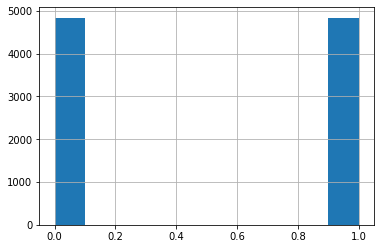

In [15]:
df_train['target'].hist()

In [16]:
SentimentML_RandF = SentimentML(RandomForestClassifier())
SentimentML_RandF.train(df_train)

AttributeError: 'list' object has no attribute 'lower'

In [ ]:
y_test = df_test['target']
y_pred_RandF = SentimentML_RandF.predict(df_test)
y_pred_proba_RandF = SentimentML_RandF.predict_proba(df_test)

print("RANDOM FOREST")

print()

acc_RandF = round(accuracy_score(y_test, y_pred_RandF)*100,2)
roc_auc_RandF = round(roc_auc_score(y_test, y_pred_proba_RandF[:,1])*100, 2)

print("accuracy score: {}%".format(acc_RandF))
print("ROC_AUC: {}%".format(roc_auc_RandF))
print()
report_RandF = classification_report(y_test, y_pred_RandF)
print(report_RandF)

ROC_curve(y_test, y_pred_proba_RandF[:,1])

In [ ]:

plt.figure(figsize = [8, 6])
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba_RandF[:,1])
auc = metrics.roc_auc_score(y_test, y_pred_proba_RandF[:,1])
plt.legend(loc=4)
plt.show()

### SVM

In [ ]:
SentimentML_SVM = SentimentML(SVC())
SentimentML_SVM.train(df_train)

# test data
y_test = df_test['target']
# predict test data
y_pred_SVM = SentimentML_SVM.predict(df_test)
#y_pred_proba_SVM = SentimentML_SVM.predict_proba(df_test)

df_pred_SVM = pd.DataFrame()
df_pred_SVM['test'] = df_test['news']
df_pred_SVM['pred_targ'] = y_pred_SVM
#df_pred_SVM['pred_prob_1'] = y_pred_proba_SVM[:,1]

print("SVM")

print()

acc_SVM = round(accuracy_score(y_test, y_pred_SVM)*100,2)
roc_auc_SVM = round(roc_auc_score(y_test, y_pred_SVM)*100, 2)

print("accuracy score: {}%".format(acc_SVM))
print("ROC_AUC: {}%".format(roc_auc_SVM))

print()
report_SVM = classification_report(y_test, y_pred_SVM)
print(report_SVM)

### Logistic Regression

In [ ]:
SentimentML_LogReg = SentimentML(LogisticRegression(max_iter = 1000))
SentimentML_LogReg.train(df_train)

# test data
y_test = df_test['target']
# predict test data
y_pred_LogReg = SentimentML_LogReg.predict(df_test)
y_pred_proba_LogReg = SentimentML_LogReg.predict_proba(df_test)

df_pred_LogReg = pd.DataFrame()
df_pred_LogReg['test'] = df_test['news']
df_pred_LogReg['pred_targ'] = y_pred_LogReg
df_pred_LogReg['pred_prob_1'] = y_pred_proba_LogReg[:,1]

print("Logistic Regression")

print()

acc_LogReg = round(accuracy_score(y_test, y_pred_LogReg)*100,2)
roc_auc_LogReg = round(roc_auc_score(y_test, y_pred_proba_LogReg[:,1])*100, 2)

print("accuracy score: {}%".format(acc_LogReg))
print("ROC_AUC: {}%".format(roc_auc_LogReg))

print()
report_LogReg = classification_report(y_test, y_pred_LogReg)
print(report_LogReg)

fpr, tpr, _ = metrics.roc_curve(y_test, stacking['stack_xgb'])
auc = metrics.roc_auc_score(df_test_Y, stacking['stack_xgb'])
auc = round(auc, 5)
plt.plot(fpr,tpr,label="SC - "+str(auc), color = 'maroon', linewidth = 0.7)

### Gradient Boosting

In [ ]:
SentimentML_GradBoost = SentimentML(GradientBoostingClassifier())
SentimentML_GradBoost.train(df_train)

# test data
y_test = df_test['target']
# predict test data
y_pred_GradBoost = SentimentML_GradBoost.predict(df_test)
y_pred_proba_GradBoost = SentimentML_GradBoost.predict_proba(df_test)

df_pred_GradBoost = pd.DataFrame()
df_pred_GradBoost['test'] = df_test['news']
df_pred_GradBoost['pred_targ'] = y_pred_GradBoost
df_pred_GradBoost['pred_prob_1'] = y_pred_proba_GradBoost[:,1]

print("Gragient Boosting")

print()

acc_GradBoost = round(accuracy_score(y_test, y_pred_GradBoost)*100,2)
roc_auc_GradBoost = round(roc_auc_score(y_test, y_pred_proba_GradBoost[:,1])*100, 2)

print("accuracy score: {}%".format(acc_GradBoost))
print("ROC_AUC: {}%".format(roc_auc_GradBoost))

print()
report_GradBoost = classification_report(y_test, y_pred_GradBoost)
print(report_GradBoost)

## Compare Models

In [ ]:
d_acc = {
            'Models' : ['RandForest', 'SVM', 'LogRegression', 'GradBoost'],
            'Accuracy' : [acc_RandF, acc_SVM, acc_LogReg, acc_GradBoost]
        }

d_roc = {
            'Models' : ['RandForest', 'SVM', 'LogRegression', 'GradBoost'],
            'ROC AUC' : [roc_auc_RandF, roc_auc_SVM, roc_auc_LogReg, roc_auc_GradBoost]
        }

df_acc = pd.DataFrame(data = d_acc)
df_roc = pd.DataFrame(data = d_roc)

In [ ]:
df_acc.sort_values('Accuracy', ascending = False)

In [ ]:
df_roc.sort_values('ROC AUC', ascending = False)

In [ ]:
df_acc.sort_values('Accuracy', ascending = False)

In [ ]:
df_roc.sort_values('ROC AUC', ascending = False)

## Test data

In [ ]:
# real data

real_class_counts_test = y_test.value_counts().to_frame().reset_index()

sns.barplot(y = real_class_counts_test['target'], x = real_class_counts_test['index'])

In [ ]:
# pred data

pred_class_counts_test = y_test.value_counts().to_frame().reset_index()

sns.barplot(y = pred_class_counts_test['target'], x = pred_class_counts_test['index'])

In [ ]:
df_pred['test'] = df_test['news']
df_pred['pred_targ'] = y_pred

df_pred.head(50)

sns.distplot(y_pred_proba[:,1])

In [ ]:
news_amazon = """Bad news, Amazon investors: The company’s stock, already down 10% from its late-July high, is likely to decline even further.
                 That’s because of the behavior of Wall Street analysts, whose earnings revisions tend to come in waves. And the vast majority of those revisions recently have been to the downside.
                 """

# news_amazon_bad = """Amazon just got some bad news. The Wall Street Journal reported today an investigation found that over 4,000 products listed on Amazon are actually banned, mislabeled, or not allowed for sale in the United States. Many of these were products, including toys and safety gear like helmets, for example, were deemed unsafe for children.
# If your company's brand is that it's the place to go to buy just about everything, the last thing you want is for consumers to think you can't be trusted. 
# As bad as that news was, the bigger story wasn't the products themselves but the ways Amazon handles its listings. The Wall Street Journal headline said Amazon had "ceded control" of its store, and the report claimed the company operated more like a "flea market," failing to adhere to its own policies.
# An Amazon spokesperson I spoke with said a statement on the company's blog was the only comment it would be making. That statement didn't deny the Journal's report outright, but laid out what the company calls it's "industry-leading safety and compliance program."
# That program includes vetting sellers when they create an account, scanning listings on the site for ones that might cause problems, and removing products in violation of Amazon's policies or government regulations. According to the Journal, Amazon removed 57 percent of the listings brought to its attention by the investigation."""

data = [[news_amazon, None]]
df_real = pd.DataFrame(data, columns = ['news', 'target'])

df_real.head()

df_real['target'] = SentimentML.predict(df_real)

df_real.head()

In [ ]:
# read data to predict

df_to_pred = pd.read_excel(path + 'data/AmazonNews.xlsx', encoding = 'utf8')
df_to_pred['news'] = df_to_pred['Заголовок новости']
remove_columns = ['Дата', 'Время', 'Заголовок новости', 'Unnamed: 3', 'Unnamed: 4',
                 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Matt Day (author)']

df_to_pred.drop(axis = 1, columns = remove_columns, inplace = True)
df_to_pred['target'] = np.nan
df_to_pred.head(31)

## Real Data

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/stalker/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/stalker/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


                                                 news  target  prob_of_1
0   Amazon Plans to Offer Telehealth Services to O...       1       0.82
1   Who Helps Pay Amazon, Walmart and McDonald's W...       1       0.66
2   Amazon’s New Grocery Store Chain Is More Tradi...       1       0.82
3   Why Amazon, Google, and Microsoft Are Designin...       1       0.63
4   Apple and Amazon Buy Into Push to Make India M...       1       0.79
5                 Amazon Sued for Alleged Hiring Bias       1       0.98
6   Bezos-Backed Vegan Milk Startup in Chile Eyes ...       1       0.90
7   Amazon Spends $131 Million for Stake in Cargo ...       1       0.88
8   Amazon Union Vote Hit By Conspiracy Theories, ...       1       0.68
9   Amazon Opening Cashierless Store in London, Fi...       1       0.69
10  Amazon Go Rival Bets Pandemic Made Case for Ca...       1       0.83
11  Amazon's (AMZN) Andy Jassy Will Take Over Jeff...       1       0.88
12  Amazon Bid to Delay Union Vote Rejected; Ballo.

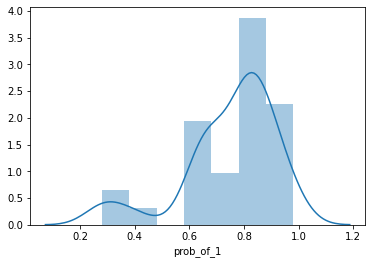

In [ ]:
df_train = df

SentimentML = SentimentML_RandForest()
SentimentML.train(df_train)
df_to_pred['target'] = SentimentML.predict(df_to_pred)
df_to_pred['prob_of_1'] = SentimentML.predict_proba(df_to_pred)[:,1]

sns.distplot(df_to_pred['prob_of_1'])

df_to_pred.to_csv(path + "data/Amazon_pred.csv")

print(df_to_pred)

## Real Data News

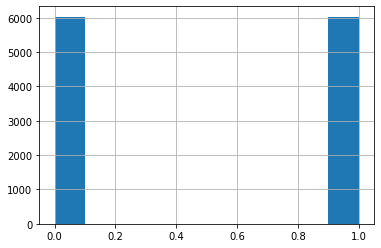

In [ ]:
df_train['target'].hist()

In [ ]:
df_train = df
SentimentML_RandF_whole = SentimentML(RandomForestClassifier())
SentimentML_RandF_whole.train(df_train)

24642


In [ ]:
# read data to predict

df_to_pred = pd.read_csv(path + 'data/amz_parsed_news.csv', index_col = 0, encoding = 'utf8')
df_to_pred['target'] = np.nan
df_to_pred.head(31)

,news,dates,target
0,‘Hermit of the Jungle’ Guards a Brazilian Ghos...,2015-05-09,NaN
1,Forwarding Text Messages on the iPhoneYou can ...,2015-05-23,NaN
2,Chinese Plan Investments and Loans for BrazilP...,2015-05-20,NaN
3,Who Is the Biggest Publisher of Foreign Litera...,2015-04-30,NaN
4,Amazon Forest Becoming Less of a Climate Chang...,2015-03-24,NaN
6,"PBS Series Explores ‘A New Wild’ Sustained, In...",2015-02-04,NaN
7,Keeping Tabs on Best-Seller Books and Reading ...,2015-02-05,NaN
8,"For the Indie Writers of Amazon, It’s Publish ...",2015-01-04,NaN
9,Writers Are Mixed Over Amazon UnlimitedSix mon...,2015-01-01,NaN
10,Deforestation May Threaten Majority of Amazon ...,2015-11-21,NaN


In [ ]:
# predict real data

df_to_pred['target'] = SentimentML_RandF_whole.predict(df_to_pred)
df_to_pred['prob_of_1'] = SentimentML_RandF_whole.predict_proba(df_to_pred)[:,1]

df_to_pred.to_csv(path + "data/Amazon_NLP_pred.csv")

df_to_pred.head(31)

,news,dates,target,prob_of_1
0,‘Hermit of the Jungle’ Guards a Brazilian Ghos...,2015-05-09,1,0.88
1,Forwarding Text Messages on the iPhoneYou can ...,2015-05-23,1,0.83
2,Chinese Plan Investments and Loans for BrazilP...,2015-05-20,1,0.80
3,Who Is the Biggest Publisher of Foreign Litera...,2015-04-30,1,0.76
4,Amazon Forest Becoming Less of a Climate Chang...,2015-03-24,1,0.89
6,"PBS Series Explores ‘A New Wild’ Sustained, In...",2015-02-04,1,0.88
7,Keeping Tabs on Best-Seller Books and Reading ...,2015-02-05,1,0.91
8,"For the Indie Writers of Amazon, It’s Publish ...",2015-01-04,1,0.55
9,Writers Are Mixed Over Amazon UnlimitedSix mon...,2015-01-01,1,0.91
10,Deforestation May Threaten Majority of Amazon ...,2015-11-21,1,0.87


In [ ]:
df_to_pred['news']

0      ‘Hermit of the Jungle’ Guards a Brazilian Ghos...
1      Forwarding Text Messages on the iPhoneYou can ...
2      Chinese Plan Investments and Loans for BrazilP...
3      Who Is the Biggest Publisher of Foreign Litera...
4      Amazon Forest Becoming Less of a Climate Chang...
                             ...                        
115    12 Accusations in the Damning House Report on ...
116    Introducing ‘Time,’ a Film From The Times and ...
117    The World’s Largest Tropical Wetland Has Becom...
118    Could the Amazon Save Your Life?Scientists are...
119    Amazon 4.0. How to Reinvent the RainforestIt t...
Name: news, Length: 114, dtype: object

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


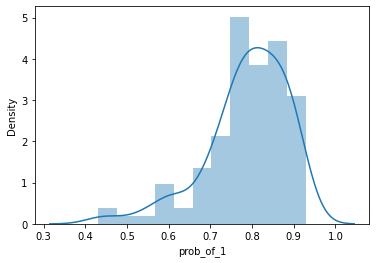

In [ ]:
sns.distplot(df_to_pred['prob_of_1'])

# Sentiment: Deep Learning

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch #pytorch
import torch.nn as nn #for our model class
import torch.nn.functional as F
from nltk.corpus import stopwords #removing stop words
from collections import Counter #counting the unique numbers
import string 
import re #regex
import seaborn as sns #plotting
import matplotlib.pyplot as plt #plotting
from torch.utils.data import TensorDataset, DataLoader #data prep
from sklearn.model_selection import train_test_split #

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used") 

GPU is available


In [ ]:
df = pd.read_csv(path + 'data/all_dfs.csv', index_col = 0)
df

In [ ]:
X,y = df['news'].values,df['target'].values
x_train,x_test,y_train,y_test = train_test_split(X,y,stratify=y)
print(f'shape of train data is {x_train.shape}')
print(f'shape of test data is {x_test.shape}')

shape of train data is (15323,)
shape of test data is (5108,)


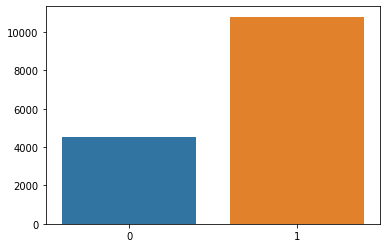

In [ ]:
dd = pd.Series(y_train).value_counts()
sns.barplot(x=dd.index,y=dd.values)
plt.show()

In [ ]:
def preprocess_string(s):
    # Remove all non-word characters 
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)

    return s 

In [ ]:
def tockenize(x_train,y_train,x_val,y_val):
    word_list = []

    stop_words = set(stopwords.words('english')) #for removing stop words
    for sent in x_train:
        for word in sent.lower().split(): #lower case sentence splitted in list
            word = preprocess_string(word) #preprocess that word using the above function
            if word not in stop_words and word != '':
                word_list.append(word) #if not stop word then append
  
    corpus = Counter(word_list) #counting the words occurence
    # sorting on the basis of most common words
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:] 
    # creating a dict
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)} #this will create a dictionary with their numbers based on most common words
    
    # tockenize
    final_list_train,final_list_test = [],[]
    for sent in x_train:
            final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() if preprocess_string(word) in onehot_dict.keys()]) #picking the number of the word after preprocessing it
    for sent in x_val:
            final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() if preprocess_string(word) in onehot_dict.keys()]) #picking the number of the word after preprocessing it
            
    encoded_train = [1 if label == 1 else 0 for label in y_train] #encoding the labels
    encoded_test = [1 if label == 1 else 0 for label in y_val] 
    return np.array(final_list_train), np.array(encoded_train), np.array(final_list_test), np.array(encoded_test),onehot_dict #returning these 4 values
 

In [ ]:
x_train,y_train,x_test,y_test,vocab = tockenize(x_train,y_train,x_test,y_test) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
x_train

array([list([2554, 138, 45, 144, 43, 220, 43, 90, 136, 67]),
       list([1286, 1286, 11, 49, 82, 27, 275, 423]),
       list([3163, 15595, 18, 2899, 7978, 862, 49]), ...,
       list([5, 2225, 545, 368, 3303, 893, 5197, 4015, 321, 1312, 3748, 6893]),
       list([4519, 3, 2875, 88, 183, 41, 48, 4]),
       list([110, 73, 2519, 9306, 847, 1540])], dtype=object)

In [ ]:
print(f'Length of vocabulary is {len(vocab)}') 

Length of vocabulary is 28629


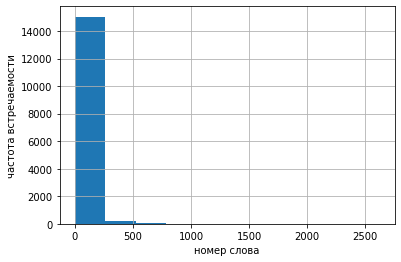

count    15323.000000
mean        22.632252
std         81.790677
min          0.000000
25%          8.000000
50%         11.000000
75%         14.000000
max       2622.000000
dtype: float64

In [ ]:
rev_len = [len(i) for i in x_train]
pd.Series(rev_len).hist()
plt.ylabel('частота встречаемости')
plt.xlabel('номер слова')
plt.show()
pd.Series(rev_len).describe() 

In [ ]:
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features 


In [ ]:
#we have very less number of reviews with length > 500.
x_train_pad = padding_(x_train,1000)
x_test_pad = padding_(x_test,1000) 

In [ ]:
x_train_pad

array([[   0,    0,    0, ...,   90,  136,   67],
       [   0,    0,    0, ...,   27,  275,  423],
       [   0,    0,    0, ..., 7978,  862,   49],
       ...,
       [   0,    0,    0, ..., 1312, 3748, 6893],
       [   0,    0,    0, ...,   41,   48,    4],
       [   0,    0,    0, ..., 9306,  847, 1540]])

In [ ]:
class LSTM(nn.Module):

    # define all the layers used in model
    def __init__(self, vocab_size, embedding_dim, lstm_units, hidden_dim , num_classes, lstm_layers,
                 bidirectional, dropout, pad_index, batch_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_index)
        self.lstm = nn.LSTM(embedding_dim,
                            lstm_units,
                            num_layers=lstm_layers,
                            bidirectional=bidirectional,
                            batch_first=True)
        num_directions = 2 if bidirectional else 1
        self.fc1 = nn.Linear(lstm_units * num_directions, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.lstm_layers = lstm_layers
        self.num_directions = num_directions
        self.lstm_units = lstm_units


    def init_hidden(self, batch_size):
        h, c = (Variable(torch.zeros(self.lstm_layers * self.num_directions, batch_size, self.lstm_units)),
                Variable(torch.zeros(self.lstm_layers * self.num_directions, batch_size, self.lstm_units)))
        return h, c

    def forward(self, text, text_lengths):
        batch_size = text.shape[0]
        h_0, c_0 = self.init_hidden(batch_size)

        embedded = self.embedding(text)
        packed_embedded = pack_padded_sequence(embedded, text_lengths, batch_first=True)
        output, (h_n, c_n) = self.lstm(packed_embedded, (h_0, c_0))
        output_unpacked, output_lengths = pad_packed_sequence(output, batch_first=True)
        out = output_unpacked[:, -1, :]
        rel = self.relu(out)
        dense1 = self.fc1(rel)
        drop = self.dropout(dense1)
        preds = self.fc2(drop)
        return preds

In [ ]:
class SentimentRNN(nn.Module):
    def __init__(self,no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5): 
        super(SentimentRNN,self).__init__()
 
        self.output_dim = output_dim #output dimensions
        self.hidden_dim = hidden_dim #hidden dimensions
  
        self.no_layers = no_layers #number of layers
        self.vocab_size = vocab_size #vocabulary size
    
        # embedding 
        self.embedding = nn.Embedding(vocab_size, embedding_dim) #embedding of vocabulary size and embedding dimensions        
        #lstm
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=self.hidden_dim,
                           num_layers=no_layers, batch_first=True)
        
        # dropout layer
        self.dropout = nn.Dropout(0.4)
    
        # linear and sigmoid layer
        #self.fc = nn.Linear(self.hidden_dim, output_dim) 
        self.fc0 = nn.Linear(self.hidden_dim, 512) #first drop out
        self.fc1 = nn.Linear(512, 256) #1st fc layer
        self.dropout1 = nn.Dropout(0.2) #2nd drop out
        self.fc = nn.Linear(256, output_dim) #2nd fully connected layer
        self.sig = nn.Sigmoid() #for last layer
        
    def forward(self,x,hidden):
        batch_size = x.size(0)
        # embeddings and lstm_out
        embeds = self.embedding(x)  # shape: B x S x Feature   since batch = True
        #print(embeds.shape)  #[50, 500, 1000]
        lstm_out, hidden = self.lstm(embeds, hidden)
        
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim) 
        
        # dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc0(out)
        out = self.dropout1(out)
        out = self.fc1(out)
        out = self.fc(out)
        
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)

        sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden
        
        
        
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden
 

In [ ]:
class LSTM_1(nn.Module):
    def __init__(self, no_layers, vocab_size, hidden_dim, embedding_dim, drop_prob=0.5, bidirectional = False, num_classes = 1): 
        super(LSTM_1,self).__init__()
 
        self.output_dim = output_dim #output dimensions
        self.hidden_dim = hidden_dim #hidden dimensions
  
        self.no_layers = no_layers #number of layers
        self.vocab_size = vocab_size #vocabulary size
    
        # embedding 
        self.embedding = nn.Embedding(vocab_size, embedding_dim) #embedding of vocabulary size and embedding dimensions        
        #lstm
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=self.hidden_dim,
                           num_layers=no_layers, bidirectional=bidirectional, batch_first=True)
        
        # dropout layer
        #self.dropout = nn.Dropout(0.4)

        num_directions = 2 if bidirectional else 1
        self.fc1 = nn.Linear(self.hidden_dim * num_directions, self.hidden_dim)
        self.fc2 = nn.Linear(self.hidden_dim, num_classes)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drop_prob)

    
        # linear and sigmoid layer
        self.fc = nn.Linear(self.hidden_dim * num_directions, output_dim) 
        """self.fc0 = nn.Linear(self.hidden_dim, 512) #first drop out
        self.fc1 = nn.Linear(512, 256) #1st fc layer
        self.dropout1 = nn.Dropout(0.2) #2nd drop out
        self.fc = nn.Linear(256, output_dim) #2nd fully connected layer"""
        self.sig = nn.Sigmoid() #for last layer
        
    def forward(self,x,hidden):
        """batch_size = text.shape[0]
        h_0, c_0 = self.init_hidden(batch_size)

        embedded = self.embedding(text)
        packed_embedded = pack_padded_sequence(embedded, text_lengths, batch_first=True)
        output, (h_n, c_n) = self.lstm(packed_embedded, (h_0, c_0))
        output_unpacked, output_lengths = pad_packed_sequence(output, batch_first=True)
        out = output_unpacked[:, -1, :]
        rel = self.relu(out)
        dense1 = self.fc1(rel)
        drop = self.dropout(dense1)
        preds = self.fc2(drop)
        return preds"""


        batch_size = x.size(0)
        # embeddings and lstm_out
        embeds = self.embedding(x)  # shape: B x S x Feature   since batch = True
        #print(embeds.shape)  #[50, 500, 1000]
        lstm_out, hidden = self.lstm(embeds, hidden)
        
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim) 
        
        # dropout and fully connected layer
        out = self.fc1(lstm_out)
        out = self.dropout(out)
        out = self.fc2(out)
        """out = self.dropout(lstm_out)
        out = self.fc0(out)
        out = self.dropout1(out)
        out = self.fc1(out)
        out = self.fc(out)"""
        
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)

        sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden
        
        
        
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden

In [ ]:
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test))

# batch size
batch_size = 50

#shuffling
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)


In [ ]:
no_layers = 4 #4 hidden LSTM stacked layers
vocab_size = len(vocab) + 1 #extra 1 for padding
embedding_dim = 64 # embedding dimensions
output_dim = 1 #single output 1 or 0
hidden_dim = 256 # hidden dimensions
drop_prob = 0.5


"""model = LSTM(self, vocab_size, embedding_dim, lstm_units, hidden_dim , num_classes, lstm_layers,
                 bidirectional, dropout, pad_index, batch_size)"""

#model = SentimentRNN(no_layers, vocab_size, hidden_dim, embedding_dim, drop_prob=0.5)
model = LSTM_1(no_layers, vocab_size, hidden_dim, embedding_dim, drop_prob, num_classes = output_dim)

#moving to gpu if available
model.to(device) 


LSTM_1(
  (embedding): Embedding(28615, 64)
  (lstm): LSTM(64, 256, num_layers=4, batch_first=True)
  (fc1): Linear(in_features=256, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)

In [ ]:
print(model) 

LSTM_1(
  (embedding): Embedding(28615, 64)
  (lstm): LSTM(64, 256, num_layers=4, batch_first=True)
  (fc1): Linear(in_features=256, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [ ]:
def acc(pred,label):
    pred = torch.round(pred.squeeze()) #remove extra dimensions
    return torch.sum(pred == label.squeeze()).item()

In [ ]:
lr=0.001 #learning rate
criterion = nn.BCELoss() #binary cross entropy for binary classification
optimizer = torch.optim.Adam(model.parameters(), lr=lr) #adam

In [ ]:
clip = 5 #gradient clipping for exploding gradients
epochs = 10 #number of epochs
valid_loss_min = np.Inf #setting loss for minimum i.e infinity epochs
# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]  #lists for appending per epochs statistics to visualize
epoch_tr_acc,epoch_vl_acc = [],[]

In [ ]:
for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()
    # initialize hidden state 
    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader: #training data
        
        inputs, labels = inputs.to(device), labels.to(device)   
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        if len(inputs) != batch_size:
          continue

        h = tuple([each.data for each in h]) 
        #print(len(inputs))
        
        model.zero_grad() #zero gradients before starting the training
        output,h = model(inputs,h) #forward pass
        
        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float()) #criterion loss
        loss.backward() # computes loss
        train_losses.append(loss.item()) #appending the loss
        # calculating accuracy
        accuracy = acc(output,labels) 
        train_acc += accuracy 

        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step() #improving the loss via optimizer using back prop (ADAM optimizer)
 
    
        
    val_h = model.init_hidden(batch_size) #initialize the hidden state
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader: #validation data

            if len(inputs) != batch_size:
                  continue
            val_h = tuple([each.data for each in val_h]) #separate variable for hidden state

            inputs, labels = inputs.to(device), labels.to(device) #checking if gpu or not

            output, val_h = model(inputs, val_h) #forward pass
            val_loss = criterion(output.squeeze(), labels.float()) # loss

            val_losses.append(val_loss.item()) #appending loss
            
            accuracy = acc(output,labels)
            val_acc += accuracy
            
    epoch_train_loss = np.mean(train_losses)  #mean of the loss for calculating epoch loss
    epoch_val_loss = np.mean(val_losses) #same for validation loss
    epoch_train_acc = train_acc / (len(train_loader.dataset) // batch_size * batch_size) #acc for epoch
    epoch_val_acc = val_acc / (len(train_loader.dataset) // batch_size * batch_size) #vali acc for epoch
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}') 
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    if epoch_val_loss <= valid_loss_min:
        torch.save(model.state_dict(), '/content/drive/MyDrive/NLP/models/df.pt') #saving the model in dictionary in .pt format
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
        valid_loss_min = epoch_val_loss
    print(25*'==') #for epoch ending symbol
 

Epoch 1
train_loss : 0.5122715294166328 val_loss : 0.4252804111616284
train_accuracy : 74.41176470588235 val_accuracy : 26.555555555555554
Validation loss decreased (inf --> 0.425280).  Saving model ...
Epoch 2
train_loss : 0.36834678959612754 val_loss : 0.3907519440148391
train_accuracy : 82.69281045751634 val_accuracy : 27.372549019607845
Validation loss decreased (0.425280 --> 0.390752).  Saving model ...
Epoch 3
train_loss : 0.26811666896238046 val_loss : 0.3833303536270179
train_accuracy : 88.09803921568627 val_accuracy : 28.013071895424837
Validation loss decreased (0.390752 --> 0.383330).  Saving model ...
Epoch 4
train_loss : 0.18149309734406036 val_loss : 0.41605236688080954
train_accuracy : 92.03921568627452 val_accuracy : 28.13071895424837
Epoch 5
train_loss : 0.12026030472571067 val_loss : 0.5290802437446865
train_accuracy : 95.02614379084967 val_accuracy : 28.22222222222222
Epoch 6
train_loss : 0.07005058287709855 val_loss : 0.5513728902328248
train_accuracy : 97.450980392

In [ ]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc') #training list
plt.plot(epoch_vl_acc, label='Validation Acc') #validation list
plt.title("Accuracy")
plt.legend() 
plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss') #training loss
plt.plot(epoch_vl_loss, label='Validation loss') #validation loss
plt.title("Loss")
plt.legend()
plt.grid() #grid 
plt.show() #showing the plots

In [ ]:
def predict_text(text):
        word_seq = np.array([vocab[preprocess_string(word)] for word in text.split() 
                         if preprocess_string(word) in vocab.keys()]) #preprocess data
        word_seq = np.expand_dims(word_seq,axis=0) #expanding the dimensions for lstm
        pad =  torch.from_numpy(padding_(word_seq,500)) #padding the sequences
        inputs = pad.to(device) #checking if gpu or not
        batch_size = 1 #batch size 1 for 1 input at 1 time
        h = model.init_hidden(batch_size) #initializing the hidden state
        h = tuple([each.data for each in h]) # hidden state variable
        output, h = model(inputs, h) #forward pass through the model
        return(output.item()) #returning the output from sigm

In [ ]:
df

,news,target
16101,rt top blockchain project buy hodl tomo tomoch...,1
4934,VNG allied hard Friday w volume.If it clears b...,1
5025,"Retail sales fell 8.7% in March, the biggest m...",0
17276,rt invest incom want steadi good reason feel p...,1
2799,CAT Gap fill area approaching. Will be filled ...,0
...,...,...
316,WETF cheap financial stock that is trying to b...,1
5630,rt buck trump health insur expand obamacar foo...,1
1030,stericycl inc srcl given consensu recommend ho...,1
21808,credit suiss group reiter price target motorol...,1


In [ ]:
import random
index = random.randint(0,len(df))
print(df['news'][index])
print(80*'=')
print("Actuall Sentiment is ", df['target'][index])
pro = predict_text(df['news'][index])
sent = 'positive' if pro >=0.5 else 'negative'
print("Predicted Sentiment is ", sent, " with a probability of ", pro) 

There’s going to be a new global giant in the payments business. Fidelity National Information Services      (ticker: FIS) said Monday that it had agreed to buy          Worldpay      (ticker: WP) for $34 billion in stock for a record international payments deal. FIS, which provides bank-office, credit-card processing and ATM services to banks, is a relatively small player in the payments business while Worldpay is a leader in that space, processing more than 40 billion transactions a year.The two companies said in a statement that they will focus on the “high-growth e-commerce” services. Shares of FIS are down almost 2% so far in trading Monday, while Worldpay stock surged about 9%There’s been a surge in mergers and acquisitions recently in the payments space. In January            Fiserv      agreed to buy          First Data      (FDC) for $22 billion.            PayPal Holdings      (PYPL) acquired iZettle for $2.2 billion last May, and private-equity firms have bought European fir

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

In [ ]:
movie_reviews = pd.read_csv(path + "data/all_dfs.csv")

movie_reviews.isnull().values.any()

movie_reviews.shape

(20431, 3)

In [ ]:
movie_reviews.head()

,Unnamed: 0,news,target
0,0,The international electronic industry company ...,0
1,1,With the new production plant the company woul...,1
2,2,According to the company 's updated strategy f...,1
3,3,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...,1
4,4,"For the last quarter of 2010 , Componenta 's n...",1


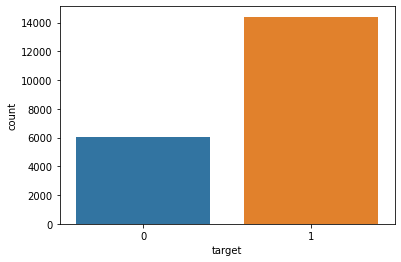

In [ ]:
import seaborn as sns

sns.countplot(x='target', data=movie_reviews)

In [ ]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [ ]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [ ]:
X = []
sentences = list(movie_reviews['news'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [ ]:
y = movie_reviews['target']

y = np.array(list(map(lambda x: 1 if x=="1" else 0, y)))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2021-05-13 17:57:07--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-05-13 17:57:07--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-05-13 17:57:08--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = "glove.6B.100d.txt"

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
print(vocab_size)

24636


In [ ]:
embedding_matrix = zeros((vocab_size, 100))

for word, index in tokenizer.word_index.items():
    #print(word, index)
    embedding_vector = embeddings_dictionary.get(word)
    #print(embedding_vector)
    if embedding_vector is not None:
        print(embedding_vector)
        embedding_matrix[index] = embedding_vector

In [ ]:
embeddings_dictionary

{'.': array([], dtype=float32),
 '0': array([], dtype=float32),
 '1': array([], dtype=float32),
 '6': array([], dtype=float32),
 'B': array([], dtype=float32),
 'd': array([], dtype=float32),
 'e': array([], dtype=float32),
 'g': array([], dtype=float32),
 'l': array([], dtype=float32),
 'o': array([], dtype=float32),
 't': array([], dtype=float32),
 'v': array([], dtype=float32),
 'x': array([], dtype=float32)}

In [ ]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())

In [ ]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

In [ ]:
score = model.evaluate(X_test, y_test, verbose=1)

In [ ]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.4466473460197449
Test Accuracy: 1.0


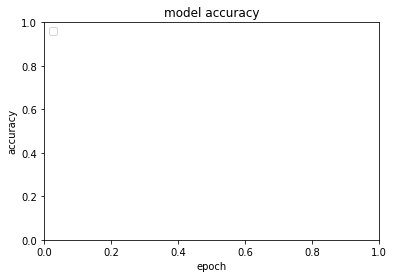

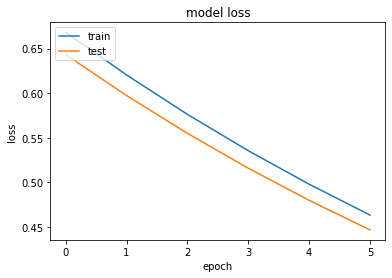

In [ ]:
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
from keras.layers.convolutional import Conv1D
model = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
print(model.summary())

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 100, 100)          2463600   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 2,527,857
Trainable params: 64,257
Non-trainable params: 2,463,600
_________________________________________________________________
None


In [ ]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)

Epoch 1/6
103/103 [==============================] - 1s 8ms/step - loss: 0.6805 - acc: 1.0000 - val_loss: 0.6434 - val_acc: 1.0000
Epoch 2/6
103/103 [==============================] - 1s 6ms/step - loss: 0.6317 - acc: 1.0000 - val_loss: 0.5974 - val_acc: 1.0000
Epoch 3/6
103/103 [==============================] - 1s 6ms/step - loss: 0.5866 - acc: 1.0000 - val_loss: 0.5550 - val_acc: 1.0000
Epoch 4/6
103/103 [==============================] - 1s 5ms/step - loss: 0.5450 - acc: 1.0000 - val_loss: 0.5159 - val_acc: 1.0000
Epoch 5/6
103/103 [==============================] - 1s 5ms/step - loss: 0.5067 - acc: 1.0000 - val_loss: 0.4798 - val_acc: 1.0000
Epoch 6/6
128/128 [==============================] - 0s 2ms/step - loss: 0.4466 - acc: 1.0000


In [ ]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.4466473460197449
Test Accuracy: 1.0


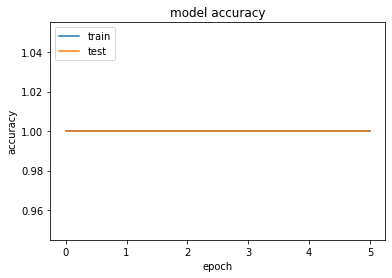

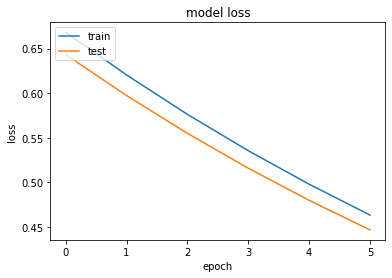

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM 
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D

In [ ]:
df = pd.read_csv(path + "data/all_dfs.csv")

In [ ]:
df.head(10)

,Unnamed: 0,news,target
0,0,The international electronic industry company ...,0
1,1,With the new production plant the company woul...,1
2,2,According to the company 's updated strategy f...,1
3,3,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...,1
4,4,"For the last quarter of 2010 , Componenta 's n...",1
5,5,"In the third quarter of 2010 , net sales incre...",1
6,6,Operating profit rose to EUR 13.1 mn from EUR ...,1
7,7,"Operating profit totalled EUR 21.1 mn , up fro...",1
8,8,TeliaSonera TLSN said the offer is in line wit...,1
9,9,"STORA ENSO , NORSKE SKOG , M-REAL , UPM-KYMMEN...",1


In [ ]:
X = df.news.values
y = df.target.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
#sentiment_label = df.target.factorize()

tweet = X_train
sentiment_label = y_train

In [ ]:
sentiment_label

array([0, 1, 0, ..., 1, 1, 1])

In [ ]:
#tweet = df.news.values

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(tweet)

vocab_size = len(tokenizer.word_index) + 1
encoded_docs = tokenizer.texts_to_sequences(tweet)
padded_sequence = pad_sequences(encoded_docs, maxlen=200)

In [ ]:
#sentiment_label = df.target.factorize()

tweet_test = X_test
tw = tokenizer.texts_to_sequences(tweet_test)
tw_test = pad_sequences(tw,maxlen=200)

In [ ]:
print(tweet[0])
print(encoded_docs[0])

snap fight everi day bull day bear day money everyon
[1407, 2114, 1094, 88, 763, 88, 1032, 88, 339, 3617]


In [ ]:
print(padded_sequence[0])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0 1407 2114 1094   88  763   88
 1032 

## LSTM

In [ ]:
embedding_vector_length = 32
model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length,     
                                     input_length=200) )
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam', 
                           metrics=['accuracy'])
print(model.summary()) 

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 200, 32)           922656    
_________________________________________________________________
spatial_dropout1d_8 (Spatial (None, 200, 32)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 50)                16600     
_________________________________________________________________
dropout_8 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 51        
Total params: 939,307
Trainable params: 939,307
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history = model.fit(padded_sequence,sentiment_label,
                  validation_split=0.2, epochs=5, batch_size=32)

Epoch 1/5
409/409 [==============================] - 262s 635ms/step - loss: 0.5548 - accuracy: 0.7234 - val_loss: 0.3548 - val_accuracy: 0.8318
Epoch 2/5
409/409 [==============================] - 258s 630ms/step - loss: 0.2979 - accuracy: 0.8672 - val_loss: 0.3130 - val_accuracy: 0.8648
Epoch 3/5
409/409 [==============================] - 260s 635ms/step - loss: 0.2516 - accuracy: 0.8873 - val_loss: 0.3085 - val_accuracy: 0.8694
Epoch 4/5
409/409 [==============================] - 259s 632ms/step - loss: 0.2130 - accuracy: 0.9080 - val_loss: 0.3061 - val_accuracy: 0.8730
Epoch 5/5
409/409 [==============================] - 260s 635ms/step - loss: 0.1970 - accuracy: 0.9195 - val_loss: 0.3020 - val_accuracy: 0.8767


### test

In [ ]:
"""#tweet = df.news.values

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(tweet)

vocab_size = len(tokenizer.word_index) + 1
encoded_docs = tokenizer.texts_to_sequences(tweet)
padded_sequence = pad_sequences(encoded_docs, maxlen=200)
   #prediction = int(model.predict(tw).round().item())"""
None

In [ ]:
y_pred_proba = model.predict(tw_test)
y_pred = np.array([round(i[0]) for i in y_pred_proba ])
y_pred_proba = y_pred_proba.reshape(1, -1)[0]
y_pred_proba

array([0.9975321 , 0.99978536, 0.0141617 , ..., 0.26762488, 0.998539  ,
       0.40618947], dtype=float32)

In [ ]:
y_test

array([1, 1, 0, ..., 0, 1, 0])

In [ ]:
acc = round(accuracy_score(y_test, y_pred)*100,2)
roc_auc = round(roc_auc_score(y_test, y_pred_proba)*100, 2)

print("accuracy score: {}%".format(acc))
print("ROC_AUC: {}%".format(roc_auc))

print()
report = classification_report(y_test, y_pred)
print(report)

accuracy score: 85.96%
ROC_AUC: 92.77%

              precision    recall  f1-score   support

           0       0.77      0.74      0.76      1197
           1       0.90      0.91      0.90      2890

    accuracy                           0.86      4087
   macro avg       0.83      0.83      0.83      4087
weighted avg       0.86      0.86      0.86      4087



### on marked data

In [ ]:
test = pd.read_excel(path + 'data/Размеченные данные по Amazon.xlsx', index_col = 0)
test.columns = ['news', 'target']


test['target'] = test['target']/2 + 0.5 + 0.0001
test = test[test.target != 0.5]
test['target'] = round(test['target'])

print(test.shape)

X_test = test.news.values
y_test = test.target.values

test.head()

(231, 2)


,news,target
0,Amazon Signs Woody Allen to Write and Direct T...,1.0
1,Amazon to Buy Israeli Chip DeveloperAmazon.com...,1.0
2,Movie Studio by Amazon for Screens Big and Sma...,1.0
3,"With Win, Amazon Shakes Up Yet Another Industr...",0.0
4,AmazonвЂ™s Tax Deal With Luxembourg May Break ...,0.0


In [ ]:
tweet_test = X_test
tw = tokenizer.texts_to_sequences(tweet_test)
tw_test = pad_sequences(tw,maxlen=200)

In [ ]:
len(tw)

231

In [ ]:
y_pred_proba = model.predict(tw_test)
y_pred = np.array([round(i[0]) for i in y_pred_proba ])
y_pred_proba = y_pred_proba.reshape(1, -1)[0]
y_pred_proba

array([0.99392796, 0.9638275 , 0.98139036, 0.9996767 , 0.73786664,
       0.9632196 , 0.69083536, 0.98843   , 0.9862422 , 0.16804424,
       0.9979152 , 0.23424985, 0.32808226, 0.8504371 , 0.95381963,
       0.9965119 , 0.47944131, 0.9844519 , 0.9237602 , 0.9591939 ,
       0.7383973 , 0.60804766, 0.91186506, 0.9280222 , 0.98002315,
       0.9851109 , 0.9981438 , 0.01390136, 0.18441083, 0.87918407,
       0.8163343 , 0.9712517 , 0.95730686, 0.4100756 , 0.67477137,
       0.35828412, 0.92067796, 0.58011824, 0.9630837 , 0.83118474,
       0.70305157, 0.22214393, 0.6500261 , 0.9596045 , 0.9880463 ,
       0.77361876, 0.6004744 , 0.92118895, 0.48734477, 0.9920161 ,
       0.4504372 , 0.90182495, 0.23469037, 0.94371426, 0.945546  ,
       0.2601334 , 0.9839686 , 0.06057061, 0.78718007, 0.97054535,
       0.36065057, 0.9912684 , 0.9844919 , 0.99679846, 0.7848642 ,
       0.23388784, 0.9271848 , 0.996775  , 0.9804174 , 0.94912124,
       0.9596137 , 0.18724169, 0.9955954 , 0.0983056 , 0.27119

In [ ]:
acc = round(accuracy_score(y_test, y_pred)*100,2)
roc_auc = round(roc_auc_score(y_test, y_pred_proba)*100, 2)

print("accuracy score: {}%".format(acc))
print("ROC_AUC: {}%".format(roc_auc))

print()
report = classification_report(y_test, y_pred)
print(report)

accuracy score: 63.64%
ROC_AUC: 54.53%

              precision    recall  f1-score   support

         0.0       0.37      0.27      0.31        71
         1.0       0.71      0.80      0.75       160

    accuracy                           0.64       231
   macro avg       0.54      0.53      0.53       231
weighted avg       0.61      0.64      0.62       231



In [ ]:
test_word ="Amazon set to fire 75000 workers in USA and Canada"
tw = tokenizer.texts_to_sequences([test_word])
tw = pad_sequences(tw,maxlen=200)
prediction = int(model.predict(tw).round().item())
sentiment_label[1][prediction]

IndexError: ignored

In [ ]:
test_word ="Amazon set to fire 75000 workers in USA and Canada"
tw = tokenizer.texts_to_sequences([test_word])
tw = pad_sequences(tw,maxlen=200)
prediction = int(model.predict(tw).round().item())
sentiment_label[prediction]

1

In [ ]:
tw

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0, 

In [ ]:
model.predict(tw)

array([[0.992326]], dtype=float32)

In [ ]:
test_word ="Amazon set to fire 75000 workers in USA and Canada"
tw = tokenizer.texts_to_sequences([test_word])
tw = pad_sequences(tw,maxlen=200)
prediction = int(model.predict(tw).round().item())
sentiment_label[1][prediction]

0

In [ ]:
test_word ="A georgia prosecutor said that the Atlanta-area spa shootings were hate crimes"
tw = tokenizer.texts_to_sequences([test_word])
tw = pad_sequences(tw,maxlen=200)
prediction = int(model.predict(tw).round().item())
sentiment_label[1][prediction]

0

## CNN

In [ ]:
embedding_vector_length = 32
model = Sequential()


model.add(Embedding(vocab_size, embedding_vector_length,     
                                     input_length=200) )
model.add(SpatialDropout1D(0.25))
model.add(Conv1D(128, 5, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam', 
                           metrics=['accuracy'])
print(model.summary()) 

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 200, 32)           922656    
_________________________________________________________________
spatial_dropout1d_7 (Spatial (None, 200, 32)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 196, 128)          20608     
_________________________________________________________________
dropout_7 (Dropout)          (None, 196, 128)          0         
_________________________________________________________________
dense_11 (Dense)             (None, 196, 1)            129       
Total params: 943,393
Trainable params: 943,393
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model = Sequential()

embedding_layer = Embedding(vocab_size, embedding_vector_length,     
                                     input_length=200)
model.add(embedding_layer)

model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary()) 

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 200, 32)           922656    
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 196, 128)          20608     
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 129       
Total params: 943,393
Trainable params: 943,393
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history = model.fit(padded_sequence,sentiment_label,
                  validation_split=0.2, epochs=10, batch_size=32)

Epoch 1/10
409/409 [==============================] - 5s 11ms/step - loss: 0.5185 - acc: 0.7531 - val_loss: 0.2898 - val_acc: 0.8724
Epoch 2/10
409/409 [==============================] - 4s 10ms/step - loss: 0.2180 - acc: 0.9067 - val_loss: 0.2719 - val_acc: 0.8819
Epoch 3/10
409/409 [==============================] - 4s 10ms/step - loss: 0.1500 - acc: 0.9404 - val_loss: 0.2932 - val_acc: 0.8779
Epoch 4/10
409/409 [==============================] - 4s 10ms/step - loss: 0.0965 - acc: 0.9668 - val_loss: 0.3569 - val_acc: 0.8682
Epoch 5/10
409/409 [==============================] - 4s 10ms/step - loss: 0.0521 - acc: 0.9855 - val_loss: 0.4144 - val_acc: 0.8685
Epoch 6/10
409/409 [==============================] - 4s 10ms/step - loss: 0.0309 - acc: 0.9914 - val_loss: 0.4695 - val_acc: 0.8697
Epoch 7/10
409/409 [==============================] - 4s 10ms/step - loss: 0.0200 - acc: 0.9945 - val_loss: 0.5324 - val_acc: 0.8648
Epoch 8/10
409/409 [==============================] - 4s 10ms/step - 

### test

In [ ]:
y_pred_proba = model.predict(tw_test)
y_pred = np.array([round(i[0]) for i in y_pred_proba ])
y_pred_proba = y_pred_proba.reshape(1, -1)[0]
y_pred_proba

array([1.0000000e+00, 1.0000000e+00, 4.0415756e-04, ..., 7.9267345e-05,
       9.9999869e-01, 4.3655582e-02], dtype=float32)

In [ ]:
y_test

array([1, 1, 0, ..., 0, 1, 0])

In [ ]:
acc = round(accuracy_score(y_test, y_pred)*100,2)
roc_auc = round(roc_auc_score(y_test, y_pred_proba)*100, 2)

print("accuracy score: {}%".format(acc))
print("ROC_AUC: {}%".format(roc_auc))

print()
report = classification_report(y_test, y_pred)
print(report)

accuracy score: 85.78%
ROC_AUC: 91.63%

              precision    recall  f1-score   support

           0       0.77      0.74      0.75      1197
           1       0.89      0.91      0.90      2890

    accuracy                           0.86      4087
   macro avg       0.83      0.82      0.83      4087
weighted avg       0.86      0.86      0.86      4087



### on marked data

In [ ]:
test = pd.read_excel(path + 'data/Размеченные данные по Amazon.xlsx', index_col = 0)
test.columns = ['news', 'target']


test['target'] = test['target']/2 + 0.5 + 0.0001
test = test[test.target != 0.5]
test['target'] = round(test['target'])

print(test.shape)

X_test = test.news.values
y_test = test.target.values

test.head()

(231, 2)


,news,target
0,Amazon Signs Woody Allen to Write and Direct T...,1.0
1,Amazon to Buy Israeli Chip DeveloperAmazon.com...,1.0
2,Movie Studio by Amazon for Screens Big and Sma...,1.0
3,"With Win, Amazon Shakes Up Yet Another Industr...",0.0
4,AmazonвЂ™s Tax Deal With Luxembourg May Break ...,0.0


In [ ]:
tweet_test = X_test
tw = tokenizer.texts_to_sequences(tweet_test)
tw_test = pad_sequences(tw,maxlen=200)

In [ ]:
len(tw)

231

In [ ]:
y_pred_proba = model.predict(tw_test)
y_pred = np.array([round(i[0]) for i in y_pred_proba ])
y_pred_proba = y_pred_proba.reshape(1, -1)[0]
y_pred_proba

array([0.63906074, 0.6966657 , 0.6650091 , 0.8018239 , 0.56893003,
       0.6623164 , 0.74576926, 0.6709138 , 0.67499715, 0.6790034 ,
       0.69972414, 0.6314026 , 0.7112236 , 0.7462214 , 0.6657656 ,
       0.7196382 , 0.69069135, 0.6775518 , 0.6391458 , 0.7572327 ,
       0.68423396, 0.7133529 , 0.6872969 , 0.6984972 , 0.69884866,
       0.632844  , 0.7332242 , 0.60940397, 0.61183727, 0.68968165,
       0.6615232 , 0.66723526, 0.672991  , 0.69396967, 0.6795281 ,
       0.7266696 , 0.72431856, 0.66345245, 0.7134249 , 0.68119866,
       0.676015  , 0.64368314, 0.72170365, 0.7184162 , 0.6417175 ,
       0.7017198 , 0.6834043 , 0.6458946 , 0.6177735 , 0.7194608 ,
       0.7211554 , 0.71622854, 0.63156337, 0.6435624 , 0.7086685 ,
       0.6546996 , 0.6998013 , 0.70968914, 0.673693  , 0.73365325,
       0.7676746 , 0.6744424 , 0.6073553 , 0.73122185, 0.655635  ,
       0.63178724, 0.65960586, 0.71708083, 0.71121645, 0.7613928 ,
       0.68543667, 0.6066837 , 0.66233593, 0.64411044, 0.62898

In [ ]:
acc = round(accuracy_score(y_test, y_pred)*100,2)
roc_auc = round(roc_auc_score(y_test, y_pred_proba)*100, 2)

print("accuracy score: {}%".format(acc))
print("ROC_AUC: {}%".format(roc_auc))

print()
report = classification_report(y_test, y_pred)
print(report)

accuracy score: 69.26%
ROC_AUC: 45.24%

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        71
         1.0       0.69      1.00      0.82       160

    accuracy                           0.69       231
   macro avg       0.35      0.50      0.41       231
weighted avg       0.48      0.69      0.57       231



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
test_word ="Amazon set to fire 75000 workers in USA and Canada"
tw = tokenizer.texts_to_sequences([test_word])
tw = pad_sequences(tw,maxlen=200)
prediction = int(model.predict(tw).round().item())
sentiment_label[prediction]

1